# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [105]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [106]:
# Complete this cell with your code
import numpy as np
import pandas
import seaborn
import matplotlib.pyplot as plt
import shap
import sklearn, xgboost

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [107]:
# Complete this cell with your code
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets
c = wine_quality.data.original

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [108]:
X.insert(11, "color", c["color"])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  color                 6497 non-null   object 
dtypes: float64(11), object(1)
memory usage: 609.2+ KB


In [109]:
y.describe()

,quality
count,6497.000000
mean,5.818378
std,0.873255
min,3.000000
25%,5.000000
50%,6.000000
75%,6.000000
max,9.000000


Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [110]:
# Complete this cell with your code

print(f"Count of the red/white wines:\n{X["color"].value_counts()}\n")
print(f"Count of good/bad wines:\n{y['quality'].value_counts()}")

Count of the red/white wines:
color
white    4898
red      1599
Name: count, dtype: int64

Count of good/bad wines:
quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64


## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [111]:
# Complete this cell with your code
X[X["color"] == "white"].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [112]:
X[X["color"] == "red"].describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'fixed_acidity'),
  Text(1, 0, 'volatile_acidity'),
  Text(2, 0, 'citric_acid'),
  Text(3, 0, 'residual_sugar'),
  Text(4, 0, 'chlorides'),
  Text(5, 0, 'free_sulfur_dioxide'),
  Text(6, 0, 'total_sulfur_dioxide'),
  Text(7, 0, 'density'),
  Text(8, 0, 'pH'),
  Text(9, 0, 'sulphates'),
  Text(10, 0, 'alcohol')])

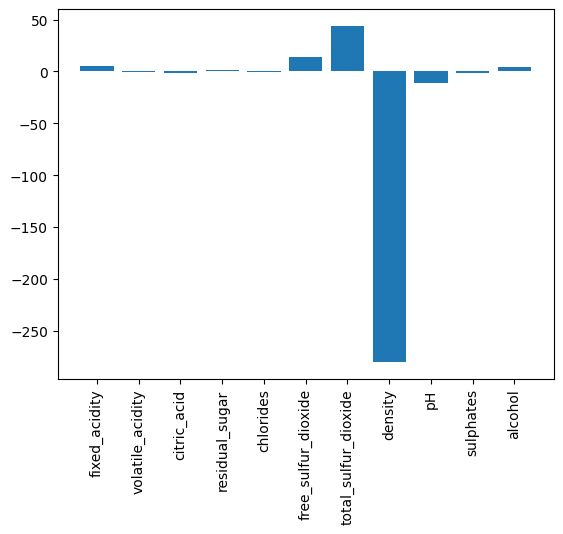

In [113]:
# Wikipedia SSMD => estimate for ssmd
import math

labels = []
xRed1 = []
xWhite1 = []
xRed2 = []
xWhite2 = []
res = []

xreddf = X[X["color"] == "red"]
xwhitedf = X[X["color"] == "white"]

for i in xreddf.columns:
    if i != "color":
        labels.append(i)
        xRed1.append(xreddf[i].mean())
        xRed2.append(xreddf[i].var())

for i in xwhitedf.columns:
    if i != "color":
        xWhite1.append(xwhitedf[i].mean())
        xWhite2.append(xwhitedf[i].var())

for idx in range(len(xRed1)):
    ssmd = xRed1[idx] - xWhite1[idx] / (math.sqrt(xRed2[idx] + xWhite2[idx]))
    res.append(ssmd)

plt.bar(labels, res)
plt.xticks(rotation=90)

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

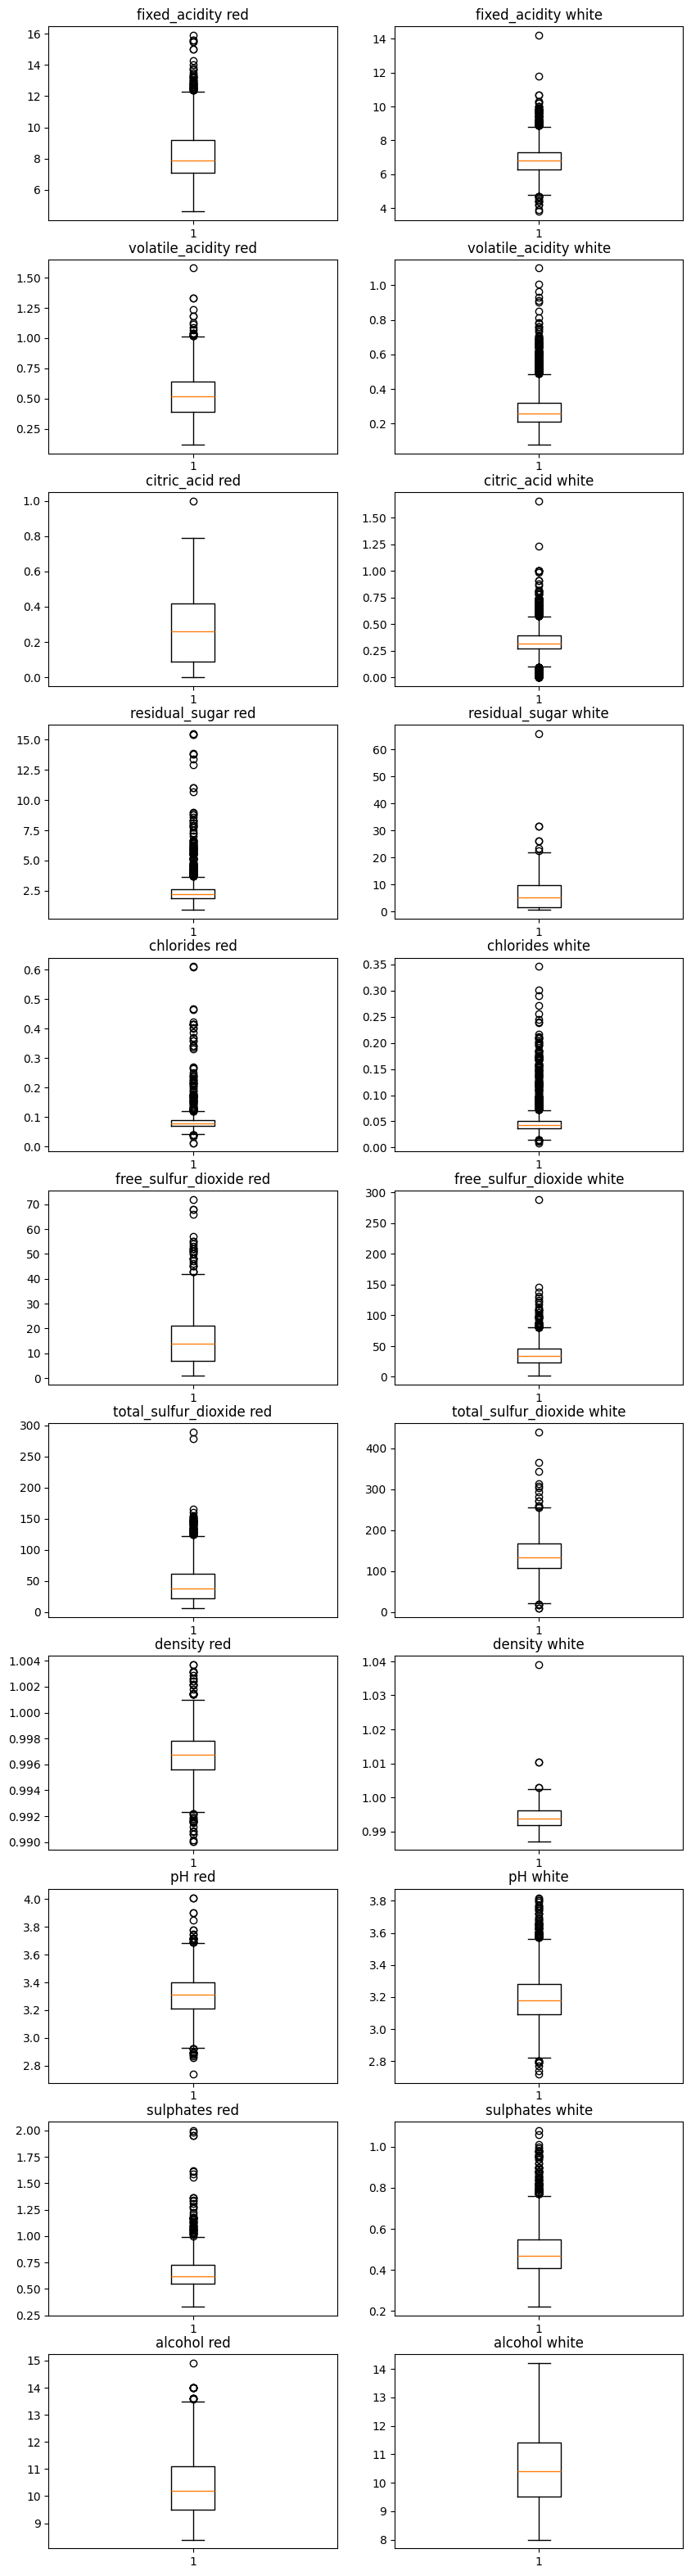

In [114]:
# Complete this cell with your code
fig, axes = plt.subplots(11, 2, figsize=(10, 40))
haha = 0
for idx, i in enumerate(xreddf.columns.values):
    if i != "color":
        axes[haha, 0].boxplot(xreddf[i])
        axes[haha, 0].set_title(i + " red")
        axes[haha, 1].boxplot(xwhitedf[i])
        axes[haha, 1].set_title(i + " white")
        haha += 1

Text(0.5, 1.0, 'white wines')

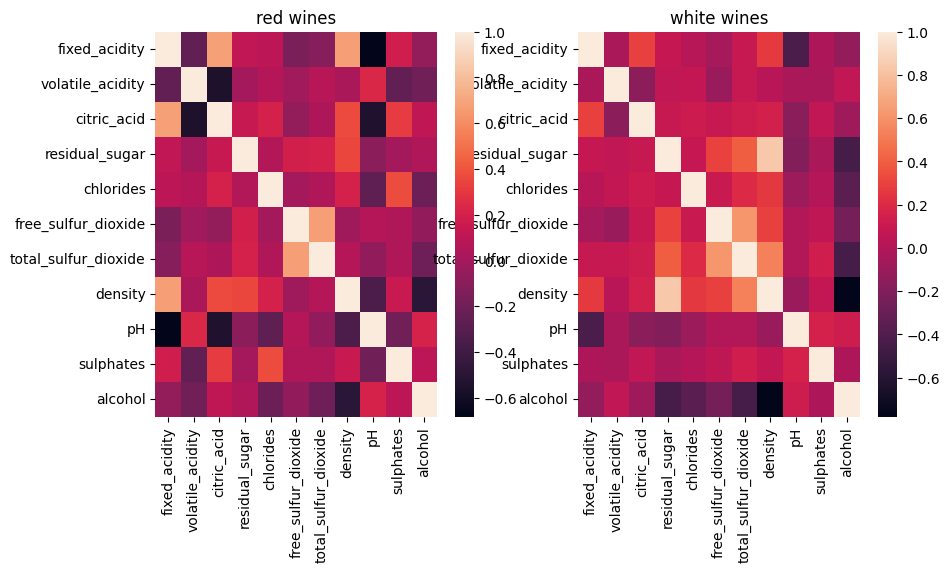

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cm1 = xreddf.loc[:, xreddf.columns != "color"].corr()
seaborn.heatmap(cm1, ax=ax[0])
ax[0].set_title("red wines")

cm2 = xwhitedf.loc[:, xwhitedf.columns != "color"].corr()
seaborn.heatmap(cm2, ax=ax[1])
ax[1].set_title("white wines")

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

([<matplotlib.axis.XTick at 0x7552511f1c10>,
 [Text(0, 1, 'fixed_acidity'),
  Text(1, 1, 'volatile_acidity'),
  Text(2, 1, 'citric_acid'),
  Text(3, 1, 'residual_sugar'),
  Text(4, 1, 'chlorides'),
  Text(5, 1, 'free_sulfur_dioxide'),
  Text(6, 1, 'total_sulfur_dioxide'),
  Text(7, 1, 'density'),
  Text(8, 1, 'pH'),
  Text(9, 1, 'sulphates'),
  Text(10, 1, 'alcohol')])

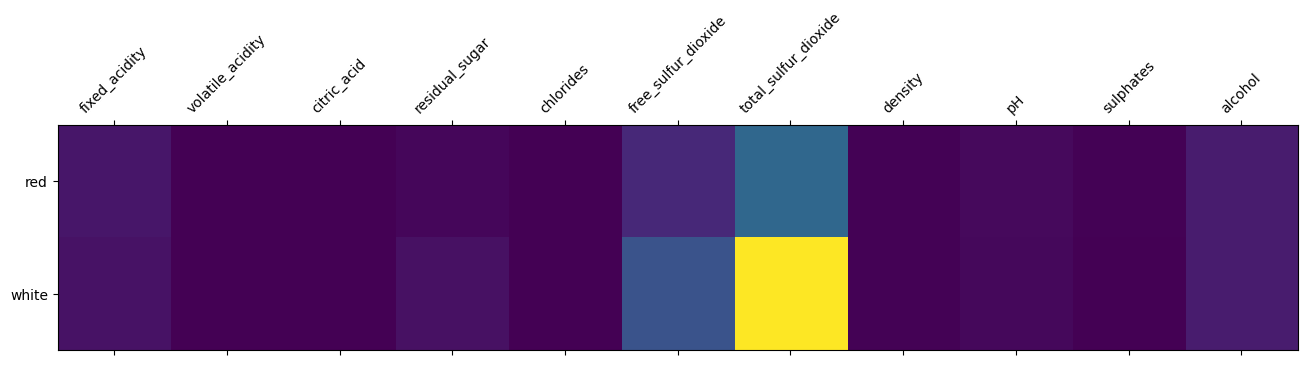

In [116]:
# Complete this cell with your code
xreddf_mean = xreddf.loc[:, xreddf.columns != "color"].mean()
xwhitedf_mean = xwhitedf.loc[:, xwhitedf.columns != "color"].mean()

yo = pandas.DataFrame(
    {
        "red": xreddf_mean.values,
        "white": xwhitedf_mean.values,
    }
)

plt.matshow(yo.transpose())
plt.yticks(labels=["red", "white"], ticks=range(2))
plt.xticks(labels=xreddf_mean.index, ticks=range(11), rotation=45)

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

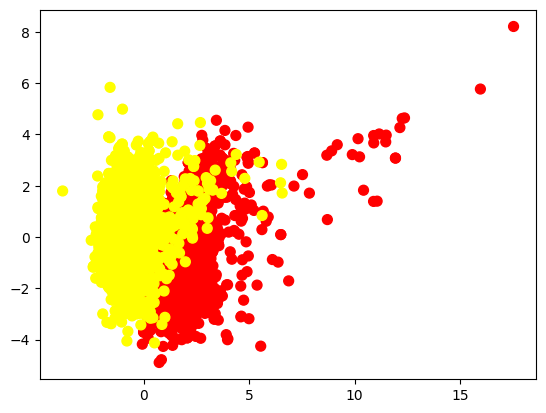

In [117]:
# Complete this cell with your code
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

scal = RobustScaler()

xNoCol = X.drop(columns="color")

cols = X["color"].to_list()

col2 = []

for i in cols:
    if i == "white":
        col2.append("yellow")
    else:
        col2.append("red")


scaledX = scal.fit_transform(xNoCol)

out = pca.fit_transform(scaledX)

plt.scatter(out[:, 0], out[:, 1], c=col2, s=50)

plt.show()

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

[[-0.82086823  0.14046696]
 [ 2.31999214 -0.39699702]]


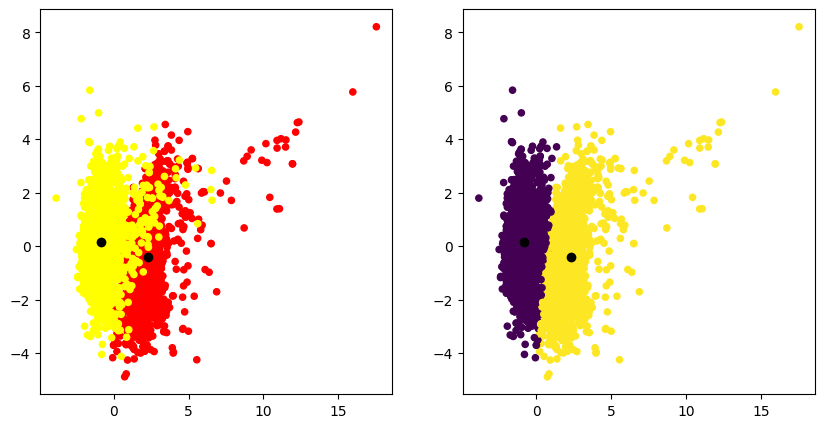

[0.79769231 0.22692308 0.78137028 0.23017706 0.18244804]
[0.76830251 0.19234143 0.75651937 0.19932248 0.15985925]
[0.33208745 0.31329265 0.29264418 0.28255142 0.37712141]


In [118]:
# Complete this cell with your code
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

kmeans = KMeans(n_clusters=2)
kmeans.fit(out)
cc = kmeans.cluster_centers_
print(cc)  # -0.8, 0.14 => white => grp0

ax[0].scatter(out[:, 0], out[:, 1], c=col2, s=20)
ax[0].scatter(cc[:, 0], cc[:, 1], c="black")
ax[1].scatter(out[:, 0], out[:, 1], c=kmeans.predict(out), s=20)
ax[1].scatter(cc[:, 0], cc[:, 1], c="black")
plt.show()

shuffeled = X.sample(frac=1)

val = cross_validate(
    kmeans,
    shuffeled.drop("color", axis=1),
    shuffeled["color"].map(lambda x: 1 if x == "red" else 0),
    cv=5,
    scoring=["accuracy", "f1_macro", "adjusted_mutual_info_score"],
)
print(val["test_accuracy"])
print(val["test_f1_macro"])
print(val["test_adjusted_mutual_info_score"])

In [119]:
# Complete this cell with your code
from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay
from sklearn.linear_model import LogisticRegression

Xtrain, Xtest, ytrain, ytest = train_test_split(X.drop("color", axis=1), X["color"])

clf = LogisticRegression(random_state=1, max_iter=1000)
parameters = [{"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

gscv = GridSearchCV(clf, parameters, scoring="f1_macro", n_jobs=6, cv=5)

gscv.fit(Xtrain, ytrain.map(lambda x: 1 if x == "red" else 0))

/home/gui/Documents/ML/w4/w4-isc-ml-GuilBess/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/gui/Documents/ML/w4/w4-isc-ml-GuilBess/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=1),
             n_jobs=6, param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}],
             scoring='f1_macro')

LogisticRegression(C=1000, max_iter=1000, random_state=1)
0.9838297884272011


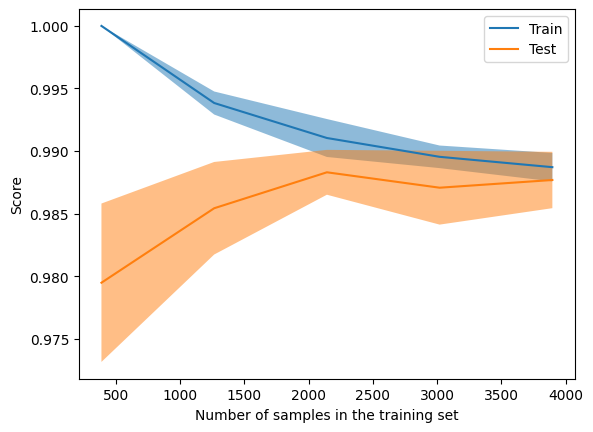

In [120]:
print(gscv.best_estimator_)
print(gscv.best_score_)
LearningCurveDisplay.from_estimator(
    gscv.best_estimator_, Xtrain, ytrain.map(lambda x: 1 if x == "red" else 0)
)

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [121]:
# Complete this cell with your code
out = []
for i in range(11):
    out.append([X.columns[i], gscv.best_estimator_.coef_[0][i]])
out

[['fixed_acidity', np.float64(1.2951895303001395)],
 ['volatile_acidity', np.float64(11.813571097329064)],
 ['citric_acid', np.float64(-1.0264939199059653)],
 ['residual_sugar', np.float64(-0.07371928996116373)],
 ['chlorides', np.float64(31.819304029210258)],
 ['free_sulfur_dioxide', np.float64(0.05082015639115678)],
 ['total_sulfur_dioxide', np.float64(-0.06275861634303294)],
 ['density', np.float64(-18.714928653335694)],
 ['pH', np.float64(8.802488867215727)],
 ['sulphates', np.float64(8.563005722043869)],
 ['alcohol', np.float64(-0.4132806715607323)]]

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

LogisticRegression(C=10, max_iter=1000, random_state=1)
0.9819619461698249


/home/gui/Documents/ML/w4/w4-isc-ml-GuilBess/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


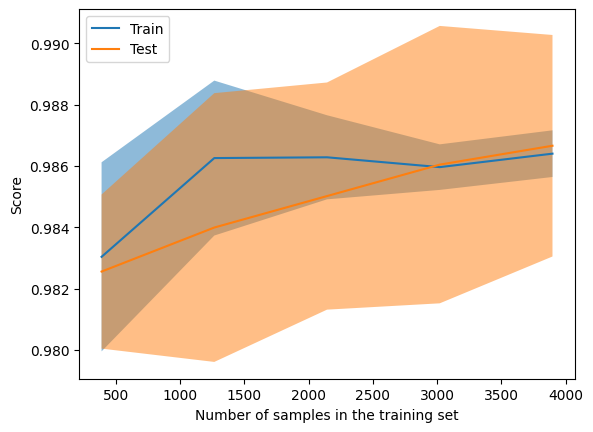

In [122]:
# Complete this cell with your code
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X.drop(["color", "chlorides"], axis=1), X["color"]
)

clf = LogisticRegression(random_state=1, max_iter=1000)
parameters = [{"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

gscv2 = GridSearchCV(clf, parameters, scoring="f1_macro", n_jobs=6, cv=5)

gscv2.fit(Xtrain, ytrain.map(lambda x: 1 if x == "red" else 0))
print(gscv2.best_estimator_)
print(gscv2.best_score_)
LearningCurveDisplay.from_estimator(
    gscv2.best_estimator_, Xtrain, ytrain.map(lambda x: 1 if x == "red" else 0)
)

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

In [123]:
# Complete this cell with your code
import xgboost

import shap

# train XGBoost model
model = xgboost.XGBClassifier().fit(
    X.drop("color", axis=1), X["color"].map(lambda x: 1 if x == "red" else 0)
)

# compute SHAP values
explainer = shap.Explainer(model, X.drop("color", axis=1))
shap_values = explainer(X.drop("color", axis=1))

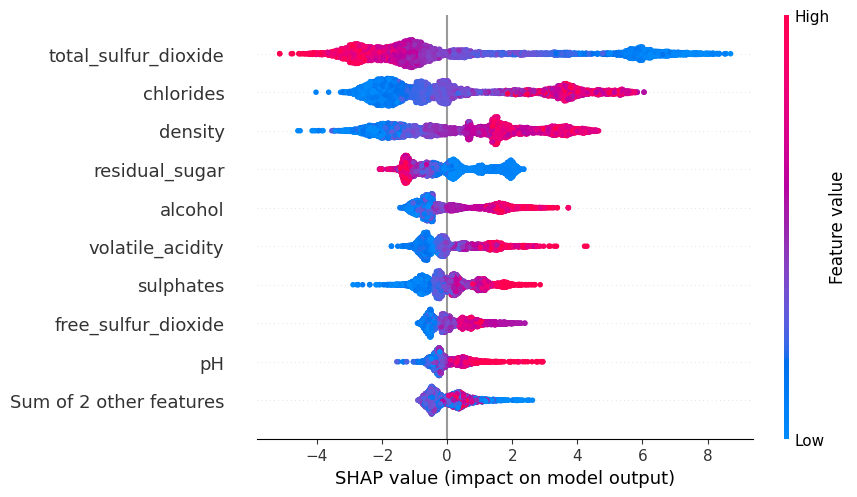

In [124]:
shap.plots.beeswarm(shap_values)

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

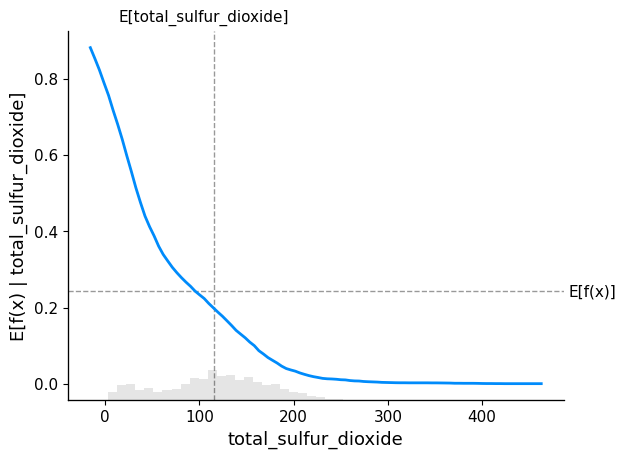

In [125]:
# Complete this cell with your code
shap.partial_dependence_plot(
    "total_sulfur_dioxide",
    gscv.best_estimator_.predict,
    X.drop("color", axis=1),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

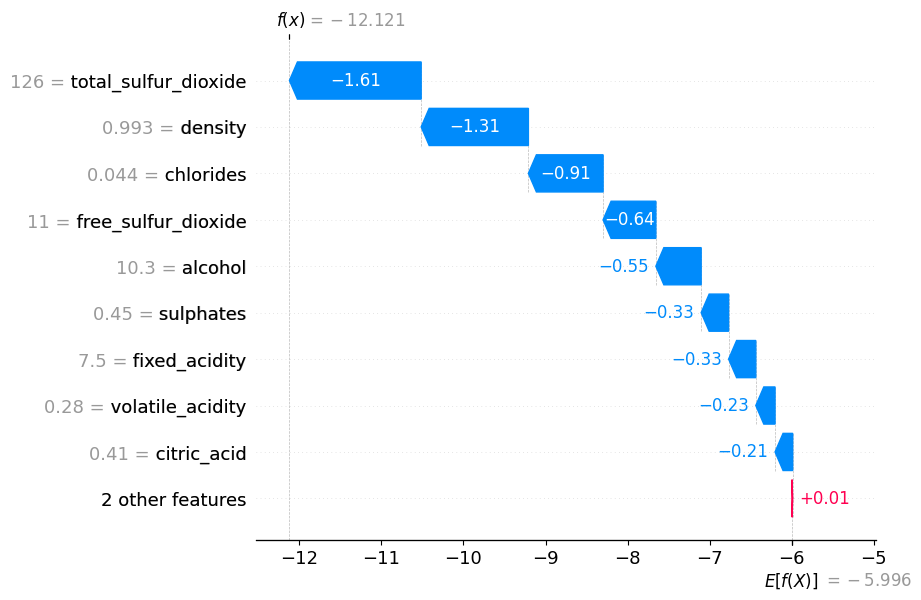

In [126]:
# Complete this cell with your code
shap.plots.waterfall(shap_values[5328])

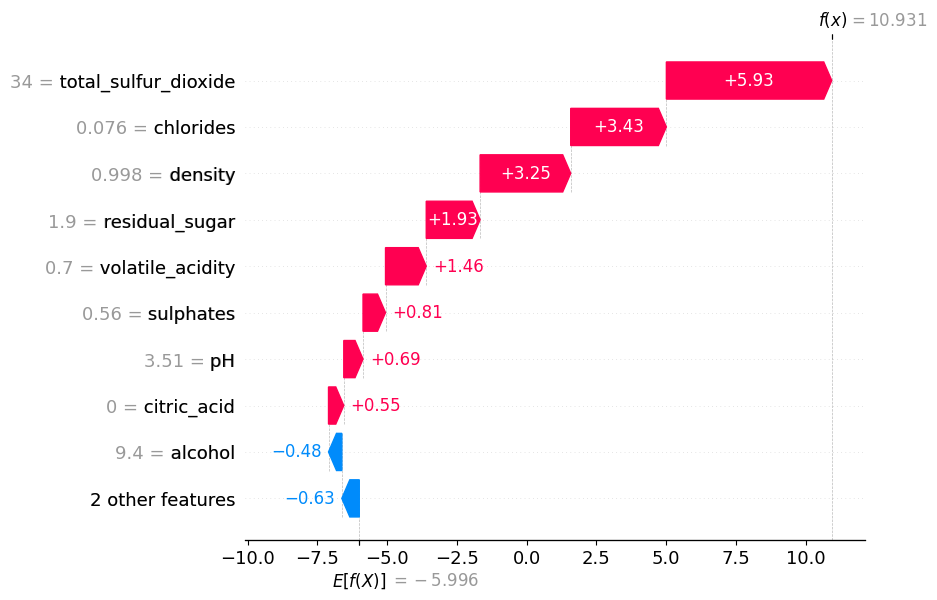

In [127]:
shap.plots.waterfall(shap_values[0])

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

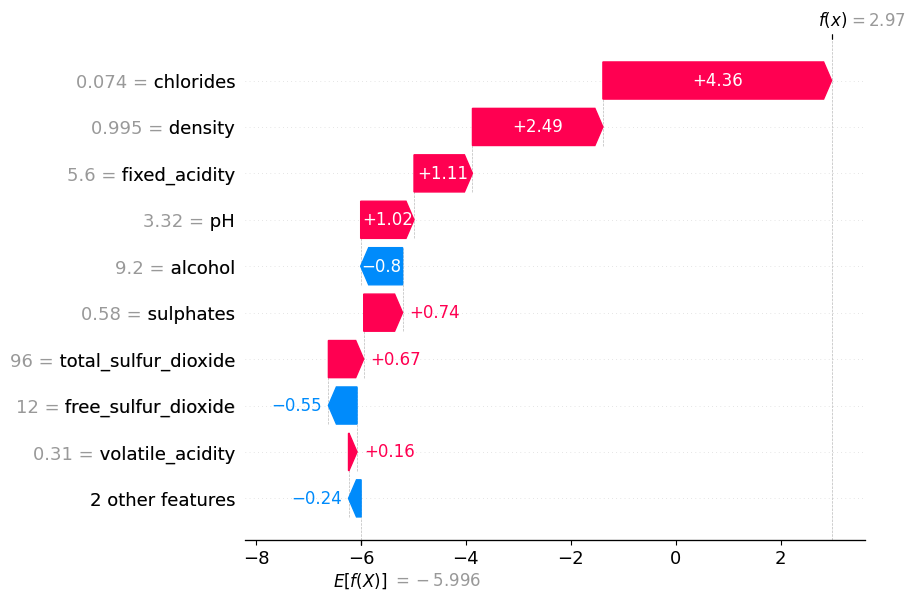

49


In [130]:
# Complete this cell with your code
for idx, i in enumerate(gscv.predict(X.drop("color", axis=1))):
    col = X["color"].iloc[idx]
    if i != (1 if col == "red" else 0):
        shap.plots.waterfall(shap_values[idx])
        print(idx)
        break

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [47]:
# Complete this cell with your code

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

In [48]:
# Complete this cell with your code

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [49]:
# Complete this cell with your code

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [50]:
# Complete this cell with your code

- Analyze the results (test and train), validate whether there is overfitting.

In [51]:
# Complete this cell with your code

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

In [52]:
# Complete this cell with your code

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

In [53]:
# Complete this cell with your code

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

In [54]:
# Complete this cell with your code

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [55]:
# Complete this cell with your code

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.